In [127]:
import numpy as np
import pandas as pd
from collections import Counter
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn import svm
import pickle

In [4]:
df = pd.read_csv('Twitter_Emotion_Dataset.csv')

df.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [5]:
df.columns

Index(['label', 'tweet'], dtype='object')

In [6]:
df.shape

(4401, 2)

In [7]:
#no nuls value
df.isnull().sum().sum()

0

In [8]:
temp = df.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet', ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet
0,anger,1101
2,happy,1017
4,sadness,997
1,fear,649
3,love,637


<Axes: xlabel='label', ylabel='count'>

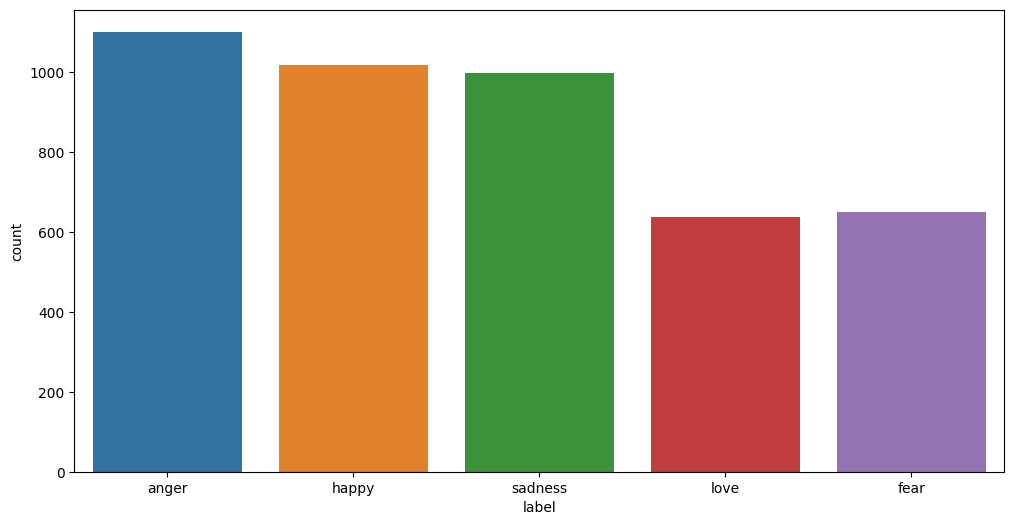

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=df)

## Preprocessing

### Case Folding

In [10]:
def case_folding(data):
  temp_tweet = []

  for tweet in data:
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    tweet = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*,]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('RT', '', tweet)
    tweet = re.sub('USERNAME', '', tweet)
    tweet = re.sub('URL', '', tweet)
    tweet = re.sub('SENSITIVE-NO', '', tweet)
    tweet = re.sub("[^a-zA-Z^']", " ", tweet)
    tweet = re.sub(" {2,}", " ", tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    tweet = tweet.lower();
    temp_tweet.append(tweet)
  return temp_tweet

In [12]:
df['tweet']=case_folding(df['tweet'])
df.head()

,label,tweet
0,anger,soal jln jatibaru polisi tdk bs geak gubernur ...
1,anger,sesama cewe lho kayaknya harusnya bisa lebih r...
2,happy,kepingin gudeg mbarek bu hj amad foto dari goo...
3,anger,jln jatibaru bagian dari wilayah tn abang peng...
4,happy,sharing pengalaman aja kemarin jam batalin tik...


### Tokenize

In [13]:
import nltk
nltk.download('punkt')

def tokenized(data):
  return data.apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
df['tweet']=tokenized(df['tweet'])
df.head()

,label,tweet
0,anger,"[soal, jln, jatibaru, polisi, tdk, bs, geak, g..."
1,anger,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,happy,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,anger,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
4,happy,"[sharing, pengalaman, aja, kemarin, jam, batal..."


### Stemming

In [15]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00


In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  return [stemmer.stem(tweet) for tweet in data]

In [17]:
df['tweet'] = df['tweet'].apply(stemming)
df.head()

,label,tweet
0,anger,"[soal, jln, jatibaru, polisi, tdk, bs, geak, g..."
1,anger,"[sama, cewe, lho, kayak, harus, bisa, lebih, r..."
2,happy,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,anger,"[jln, jatibaru, bagi, dari, wilayah, tn, abang..."
4,happy,"[sharing, alam, aja, kemarin, jam, batalin, ti..."


### Slang Word

In [21]:
slang_df = pd.read_csv('kamus_singkatan.csv', names=['Old', 'New'], header=None, sep=";")
slang_df.head()

,Old,New
0,aamiin,amin
1,adek,adik
2,adlh,adalah
3,aer,air
4,aiskrim,es krim


In [22]:
slang_df['Old'] = slang_df['Old'].apply(lambda x: x.strip())
slang_df['New'] = slang_df['New'].apply(lambda x: x.strip())

In [23]:
slang_dict = {}
for i, row in slang_df.iterrows():
  slang_dict.update({row['Old']: row['New']})

In [24]:
def removeSlang(data):
  for i, word in enumerate(data):
    # check if data in slang dictionary or not
    try:
      data[i] = slang_dict[word]
    # if data is not slang then pass
    except KeyError:
      pass
  return data

In [25]:
df['tweet'] = df['tweet'].apply(removeSlang)
df.head()

,label,tweet
0,anger,"[soal, jalan, jatibaru, polisi, tidak, bisa, g..."
1,anger,"[sama, cewek, lho, mirip, harus, bisa, lebih, ..."
2,happy,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,anger,"[jalan, jatibaru, bagi, dari, wilayah, tn, aba..."
4,happy,"[sharing, alam, saja, kemarin, jam, batalin, t..."


### Stop Words Removal

In [26]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def removeStopWords(data):
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
df['tweet']=removeStopWords(df['tweet'])
df.head()

,label,tweet
0,anger,"[jalan, jatibaru, polisi, geak, gubernur, eman..."
1,anger,"[cewek, lho, rasain, sibuk, jaga, rasain, saki..."
2,happy,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
3,anger,"[jalan, jatibaru, wilayah, tn, abang, atur, wi..."
4,happy,"[sharing, alam, kemarin, jam, batalin, tiket, ..."


Kombinasi menjadi data dalam satu string

In [28]:
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))
df.head()

,label,tweet
0,anger,jalan jatibaru polisi geak gubernur emangny po...
1,anger,cewek lho rasain sibuk jaga rasain sakit haid ...
2,happy,kepingin gudeg mbarek bu hj amad foto google s...
3,anger,jalan jatibaru wilayah tn abang atur wilayah t...
4,happy,sharing alam kemarin jam batalin tiket stasiun...


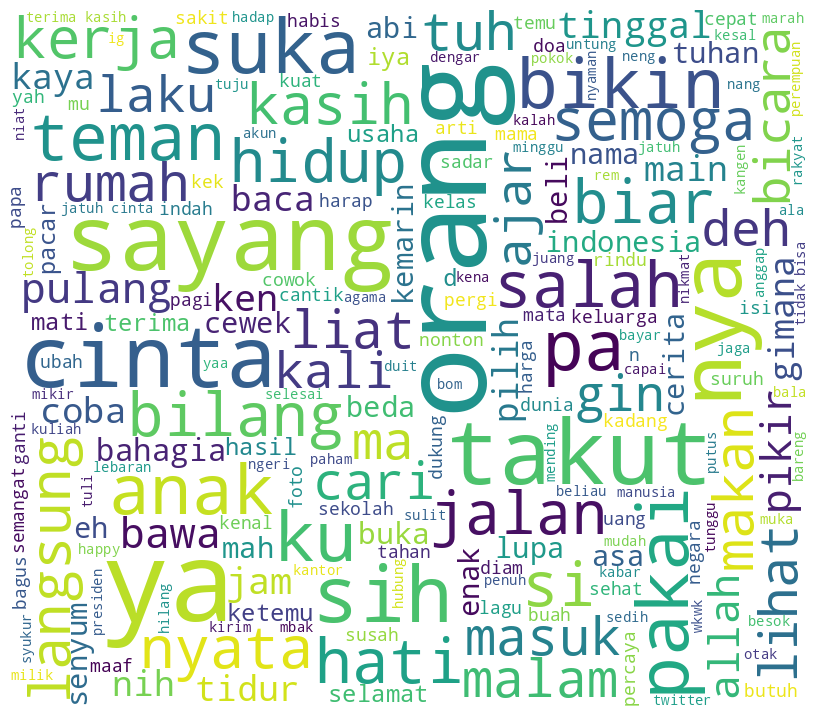

In [29]:
stopwords=set(STOPWORDS)
wordclouds=WordCloud(width=800,
                    height=700,
                    background_color='white',
                    max_font_size=120,
                    min_font_size=10,
                    stopwords=stopwords).generate(''.join(df['tweet']))

#plot the worldcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordclouds)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

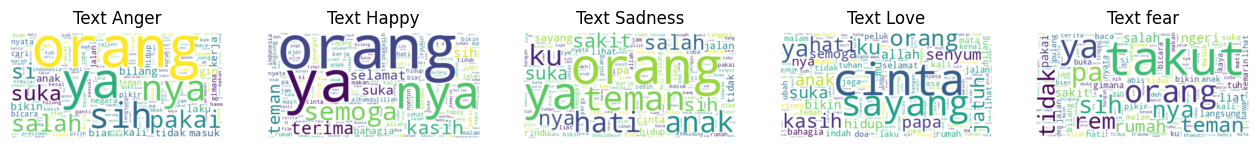

In [35]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5 , figsize=(16,8))
text_anger = " ".join(df['tweet'][df.label == 'anger'])
text_happy = " ".join(df['tweet'][df.label == 'happy'])
text_sadness = " ".join(df['tweet'][df.label == 'sadness'])
text_love = " ".join(df['tweet'][df.label == 'love'])
text_fear = " ".join(df['tweet'][df.label == 'fear'])
train_cloud_anger = WordCloud(collocations = False, background_color = 'white').generate(text_anger)
train_cloud_happy = WordCloud(collocations = False, background_color = 'white').generate(text_happy)
train_cloud_sadness = WordCloud(collocations = False, background_color = 'white').generate(text_sadness)
train_cloud_love = WordCloud(collocations = False, background_color = 'white').generate(text_love)
train_cloud_fear = WordCloud(collocations = False, background_color = 'white').generate(text_fear)
axs[0].imshow(train_cloud_anger, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Text Anger')
axs[1].imshow(train_cloud_happy, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Text Happy')
axs[2].imshow(train_cloud_sadness, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title('Text Sadness')
axs[3].imshow(train_cloud_love, interpolation='bilinear')
axs[3].axis('off')
axs[3].set_title('Text Love')
axs[4].imshow(train_cloud_fear, interpolation='bilinear')
axs[4].axis('off')
axs[4].set_title('Text fear')
plt.show()

## Feature Extraction

In [53]:
X = df['tweet']
y = df['label']

In [142]:
count_vect = CountVectorizer()

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [143]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE()
tfidf_vector, label = sampler.fit_resample(X_tfidf, y)
print(tfidf_vector.shape)
print(label.shape)

(5505, 12942)
(5505,)


anger      1101
happy      1101
sadness    1101
love       1101
fear       1101
Name: label, dtype: int64


Axes(0.125,0.11;0.775x0.77)


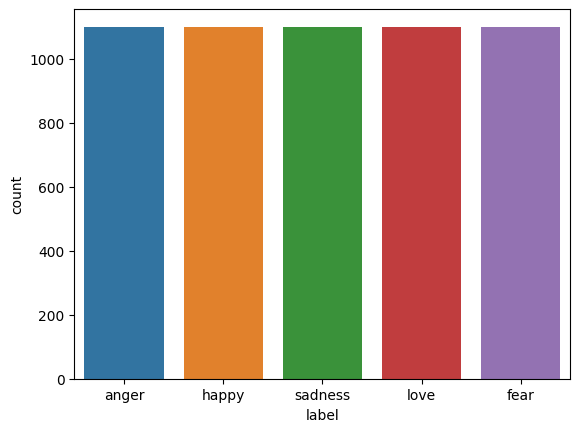

In [144]:
print(label.value_counts())
print('\n')
print(sns.countplot(x = label))

In [145]:
x_train,x_test,y_train,y_test = train_test_split(tfidf_vector,label.values,test_size=0.2,random_state=0)

## Membuat Model

In [146]:
model = svm.SVC()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)

print("Akurasi :", accuracy)

Akurasi : 0.7356948228882834


In [147]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[173   2  18   1  10]
 [ 24 170   9   0  10]
 [ 42   1 164   2  24]
 [  6   0  13 187  12]
 [ 69   5  31  12 116]]


Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 2000x800 with 0 Axes>

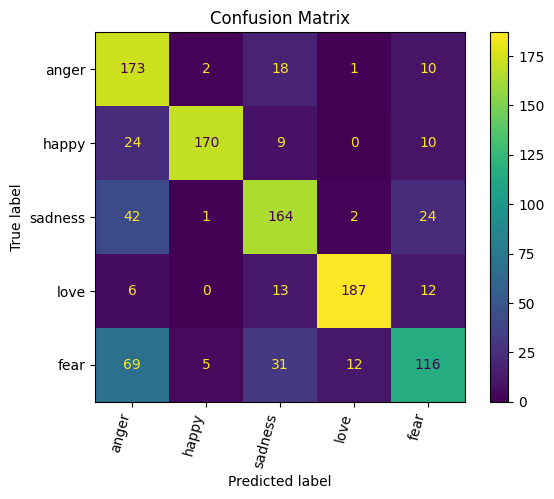

In [148]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["anger", "happy", "sadness", "love", "fear"])
fig =plt.figure(figsize=(20,8))
disp.plot()
plt.xticks(rotation = 75, ha = 'right')
plt.title('Confusion Matrix')

In [149]:
print('\n',classification_report(y_test,y_pred))
print('\nTraining Accuracy Score: ',accuracy_score(y_test,y_pred))


               precision    recall  f1-score   support

       anger       0.55      0.85      0.67       204
        fear       0.96      0.80      0.87       213
       happy       0.70      0.70      0.70       233
        love       0.93      0.86      0.89       218
     sadness       0.67      0.50      0.57       233

    accuracy                           0.74      1101
   macro avg       0.76      0.74      0.74      1101
weighted avg       0.76      0.74      0.74      1101


Training Accuracy Score:  0.7356948228882834


In [150]:
def prediksi(tweets):
  vectorized_tweets = tfidf_vectorizer.transform(tweets)
  input_prediction = model.predict(vectorized_tweets)

  print('text :', tweets[0])
  print(input_prediction)

In [158]:
prediksi(['saya cinta kamu'])

text : saya cinta kamu
['love']


In [152]:
# Simpan model ke dalam file pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Simpan model ke dalam file pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)